In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pprint import pprint

from scipy.stats import chi2_contingency, ttest_ind

In [191]:
data_active = pd.read_csv("data/mu_actives_Ki_IC50_human_and_rat_interaction_fingerprints_5c1m.csv")
data_inactive = pd.read_csv("data/mu_inactives_Ki_IC50_human_and_rat_interaction_fingerprints_5c1m.csv")

data = pd.concat((data_active, data_inactive))
X = data.loc[:, data.columns.map(lambda x: x[0]=='A')].reset_index(drop=True)
y = np.array([1]*len(data_active) + [0]*len(data_inactive))

/home/wwydmanski/.conda/envs/drug-design/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2745,2754,2775,2776,2777,2778,2779,2781,2782,2788,2789,2790) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/wwydmanski/.conda/envs/drug-design/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2740,2746,2755,2778,2779,2780,2781,2782,2784,2785,2790,2791,2792,2793) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Feature selection

### Remove columns that do not change

In [192]:
const_val = (X.max(axis=0)==X.min(axis=0))

X = X.loc[:, ~const_val]

### Remove columns that do not correlate with target value
We will be using chi-squared test for that. If the calculated p-val is <0.05 it means that we can reject the hypothesis of frequencies equality (so, in our case, it means that this _could_ potentially be an important variable).

If the p-val >0.05, there is no statisticlly significant difference between the two cohorts, so we can probably just ignore this column.

In [193]:
def check_chi2(col):
    X_true = X.loc[y==1, col].values
    X_false = X.loc[y==0, col].values

    freqs = np.array([[np.sum(X_true==0), np.sum(X_true==1)],
                      [np.sum(X_false==0), np.sum(X_false==1)]])
    chi2, p, dof, ex = chi2_contingency(freqs)    
    return p<0.05

In [194]:
correlating = X.columns[X.columns.map(check_chi2)]

In [195]:
X = X.loc[:, correlating]

In [196]:
correlating

Index(['A54_contact', 'A54_backbone', 'A54_sidechain', 'A54_polar',
       'A54_acceptor', 'A55_contact', 'A55_backbone', 'A55_sidechain',
       'A55_polar', 'A55_acceptor',
       ...
       'A326_hydrophobic', 'A326_donor', 'A326_aromatic', 'A328_contact',
       'A328_sidechain', 'A328_polar', 'A329_contact', 'A329_backbone',
       'A329_sidechain', 'A329_polar'],
      dtype='object', length=147)

### Remove identical columns
Hey, there might be some

In [197]:
def check_identity(col1, col2):
    return not all(X[col1]==X[col2])

class IdentityMap:
    def __init__(self):
        self.map = {}

    def append(self, col1, col2):
        root = None
        for i in self.map.keys():
            if col1 in self.map[i] or col2 in self.map[i]:
                root = i
                break
        if root is None:
            self.map[col1] = []
            root = col1
        
        self.map[root].extend([col1, col2])
        self.map[root] = list(set(self.map[root]))

In [198]:
identical = IdentityMap()
        
for col1 in X.columns:
    for col2 in X.columns:
        if col1 == col2:
            continue
        if not check_identity(col1, col2):
            identical.append(col1, col2)

In [199]:
redundant = []
for i in identical.map.keys():
    for col in identical.map[i]:
        if i!=col:
            redundant.append(col)

In [200]:
X = X.loc[:, ~X.columns.isin(redundant)]

### Get final columns

In [126]:
X.columns.to_frame().to_csv("significant_cols.csv", index=False)

## Difference analysis

### Interactions

In [241]:
try:
    del X["active"]
except KeyError:
    pass
X["active"] = X.sum(axis=1)
X["target"] = y

X_active = X.loc[y==1, X.columns[:-2]]
X_inactive = X.loc[y==0, X.columns[:-2]]

In [242]:
X.iloc[0][X.iloc[0]>1]

active    35
Name: 0, dtype: int64

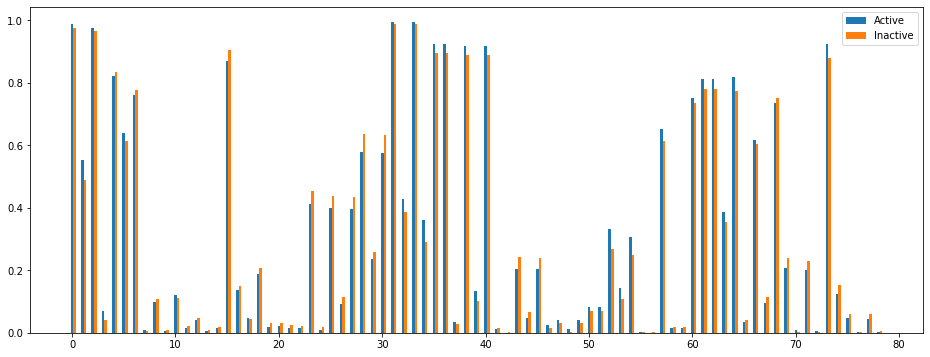

In [243]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(X_active.columns)), (X_active.sum(axis=0)/len(X_active)), width=0.25, label="Active")
plt.bar(np.arange(len(X_active.columns))+0.25, (X_inactive.sum(axis=0)/len(X_inactive)), width=0.25, label="Inactive")
plt.legend();

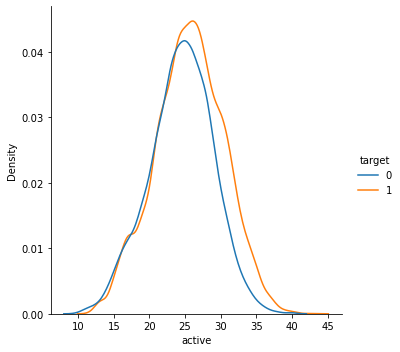

In [244]:
sns.displot(X, x="active", hue="target", kind='kde')

In [245]:
ttest_ind(X_active.sum(axis=1), X_inactive.sum(axis=1))

Ttest_indResult(statistic=3.564007603140125, pvalue=0.0003658393821058507)

The difference is not big, but it's statistically significant - active compounds have more interactions with receptor

### Nucleotides connections

In [222]:
X_collapsed = {}
nucleotides = list(set(x.split("_")[0] for x in X.columns if x[0]=="A"))

In [228]:
for nuc in nucleotides:
    X_collapsed[nuc] = X.loc[:, X.columns.map(lambda x: x.split("_")[0]==nuc)].max(axis=1)

In [231]:
X_collapsed = pd.DataFrame.from_dict(X_collapsed)
X_collapsed["target"] = X["target"]
X_collapsed["active"] = X_collapsed.sum(axis=1)

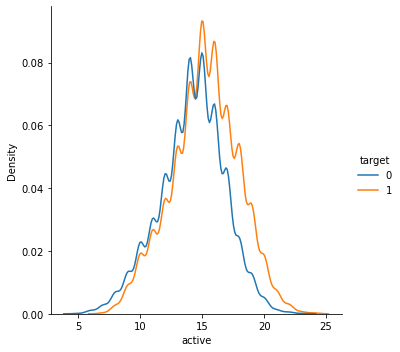

In [232]:
sns.displot(X_collapsed, x="active", hue="target", kind='kde')

In [234]:
ttest_ind(X_collapsed[X_collapsed["target"]==1]["active"], X_collapsed[X_collapsed["target"]==0]["active"])

Ttest_indResult(statistic=32.246901963144346, pvalue=4.650911163518952e-224)

Additionally, active compounds usually interact with more nucleotides at once